# Exploring Dandiset 001359: Human Patch-seq Neurophysiology Data

> **Note**: This notebook was generated with AI assistance. Users should carefully validate all code and interpretations.

## Overview
This notebook introduces [DANDI:001359](https://dandiarchive.org/dandiset/001359/0.250401.1603), a dataset containing patch-clamp recordings from human neurons. The dataset enables multimodal classification of human neuron cell types by combining electrophysiological recordings with transcriptomics at the single-cell level.

### Dataset Summary
- **Species**: Human
- **Techniques**: Patch-seq, voltage and current clamp recordings
- **Size**: 391 NWB files from 33 subjects (~23.8 GB)
- **Data Types**: Electrophysiological recordings, spike times, experimental annotations
- **Protocol**: [Patch-seq recording and extraction](https://www.protocols.io/view/patch-seq-recording-and-extraction-8epv51n45l1b/v3)

### Notebook Contents
1. Loading and inspecting NWB files
2. Exploring electrophysiology recordings
3. Analyzing spike detection data
4. Understanding experimental intervals and annotations

## Required Packages

In [1]:
import pynwb
import h5py
import remfile
from dandi.dandiapi import DandiAPIClient
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import islice

## Accessing the Dataset
First, we'll use the DANDI API to explore the dataset structure.

In [2]:
# Initialize DANDI client and access dataset
client = DandiAPIClient()
dandiset = client.get_dandiset("001359", "0.250401.1603")

# Get all .nwb assets
assets = list(dandiset.get_assets_by_glob("*.nwb"))

# Count unique subjects
subjects = set()
for asset in assets:
    parts = asset.path.split('/')
    if len(parts) > 0 and parts[0].startswith('sub-'):
        subjects.add(parts[0])

print(f"Total NWB files: {len(assets)}")
print(f"Unique subjects: {len(subjects)}")
print("\nExample file paths:")
for path in [asset.path for asset in assets][:3]:
    print(f"- {path}")

Total NWB files: 391
Unique subjects: 33

Example file paths:
- sub-1203384279/sub-1203384279_ses-1207984257_icephys.nwb
- sub-1203384279/sub-1203384279_ses-1207304122_icephys.nwb
- sub-1203384279/sub-1203384279_ses-1207262032_icephys.nwb


## Exploring an NWB File
Let's examine a representative NWB file to understand its structure and content.

In [3]:
# Load an example NWB file
nwb_path = "sub-1203384279/sub-1203384279_ses-1207984257_icephys.nwb"
asset = next(dandiset.get_assets_by_glob(nwb_path))
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Count acquisition types
acq_types = [type(obj).__name__ for obj in nwb.acquisition.values()]
type_counts = pd.Series(acq_types).value_counts()

print("Recording types in this file:")
print(type_counts)
print("\nSubject metadata:")
print(f"Species: {nwb.subject.species}")
print(f"Sex: {nwb.subject.sex}")
print(f"Age: {nwb.subject.age}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.4 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Recording types in this file:
CurrentClampSeries    59
VoltageClampSeries     7
Name: count, dtype: int64

Subject metadata:
Species: Homo sapiens
Sex: M
Age: P21170.0D


## Visualizing Electrophysiology Data
We'll plot a current clamp recording with its corresponding stimulus.

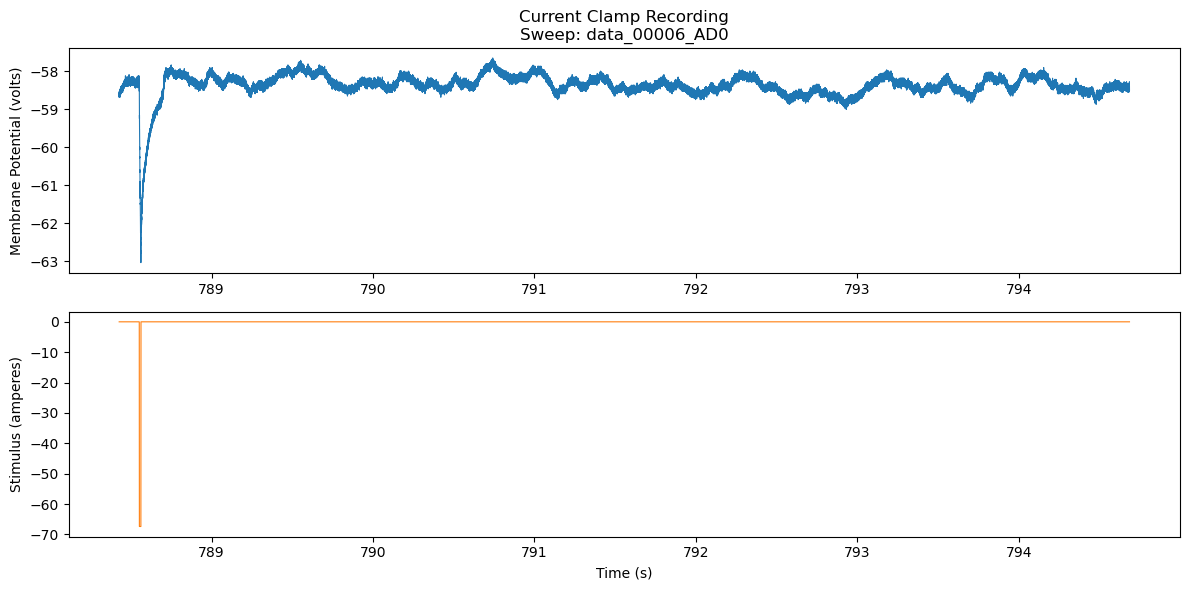

In [4]:
# Select a current clamp sweep
cc_sweeps = [(name, obj) for name, obj in nwb.acquisition.items() 
             if type(obj).__name__ == 'CurrentClampSeries']
example_sweep_name, example_sweep = cc_sweeps[0]

# Get corresponding stimulus
stim_name = example_sweep_name.replace('_AD0', '_DA0')
example_stimulus = nwb.stimulus.get(stim_name)

# Extract data
trace = example_sweep.data[:]
stim = example_stimulus.data[:] if example_stimulus is not None else None
rate = example_sweep.rate
start_time = example_sweep.starting_time
t = np.arange(len(trace)) / rate + start_time

# Create plot
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, trace, color='tab:blue', linewidth=0.8)
plt.ylabel(f"Membrane Potential ({example_sweep.unit})")
plt.title(f"Current Clamp Recording\nSweep: {example_sweep_name}")

plt.subplot(2, 1, 2)
if stim is not None:
    plt.plot(t, stim, color='tab:orange', linewidth=0.8)
    plt.ylabel(f"Stimulus ({example_stimulus.unit})")
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

## Spike Detection Analysis
Let's examine a sweep with detected spike times.

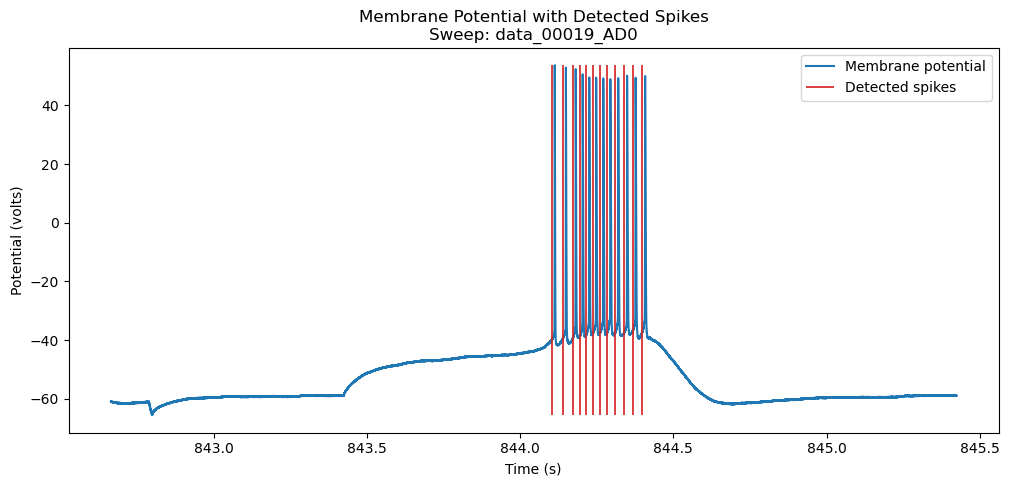

Number of detected spikes: 12


In [5]:
# Find a sweep with detected spikes
spike_mod = nwb.processing['spikes']
sweep_with_spikes = None
for name, ts in spike_mod.data_interfaces.items():
    if hasattr(ts, 'data') and len(ts.data[:]) > 0:
        sweep_with_spikes = (name, ts)
        break

if sweep_with_spikes:
    sweep_name, spike_ts = sweep_with_spikes
    # Find matching acquisition
    swnum = int(sweep_name.replace('Sweep_', ''))
    match = [(nm, obj) for nm, obj in nwb.acquisition.items() 
             if hasattr(obj, 'sweep_number') and obj.sweep_number == swnum]
    
    if match:
        acq_name, acq_obj = match[0]
        trace = acq_obj.data[:]
        rate = acq_obj.rate
        start_time = acq_obj.starting_time
        t = np.arange(len(trace)) / rate + start_time
        # Correct spike times
        spike_times = spike_ts.data[:] + start_time + 0.25
        
        # Remove NaN for plotting
        not_nan = ~np.isnan(trace)
        trace_min = np.min(trace[not_nan])
        trace_max = np.max(trace[not_nan])
        
        plt.figure(figsize=(12, 5))
        plt.plot(t, trace, label='Membrane potential', color='tab:blue')
        plt.vlines(spike_times, trace_min, trace_max, color='tab:red', 
                  label='Detected spikes', linewidth=1.25)
        plt.xlabel('Time (s)')
        plt.ylabel(f'Potential ({acq_obj.unit})')
        plt.title(f'Membrane Potential with Detected Spikes\nSweep: {acq_name}')
        plt.legend()
        plt.show()
        
        print(f"Number of detected spikes: {len(spike_times)}")

## Experimental Intervals Analysis
Finally, let's examine the experimental epoch structure.

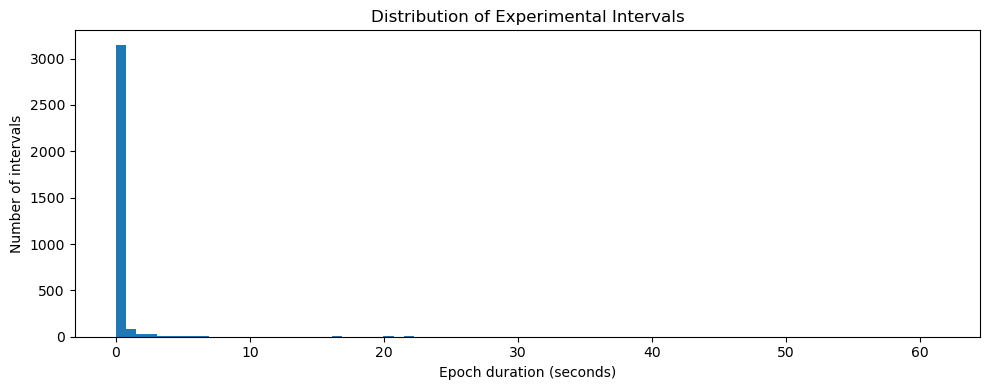

Most common experimental tags:
Type=Epoch                 2825
Epoch=1                    2666
EpochType=Sin Wave         2614
Amplitude=15               2075
Half Cycle=0                868
Half Cycle=1                865
Amplitude=14                515
EpochType=Square pulse      207
Type=Inserted Testpulse     196
Amplitude=0                 139
Name: count, dtype: int64


In [6]:
# Access all epochs
epochs_df = nwb.epochs.to_dataframe().copy()
durations = epochs_df['stop_time'] - epochs_df['start_time']

# Plot duration distribution
plt.figure(figsize=(10, 4))
plt.hist(durations, bins=80)
plt.xlabel('Epoch duration (seconds)')
plt.ylabel('Number of intervals')
plt.title('Distribution of Experimental Intervals')
plt.tight_layout()
plt.show()

# Show tag statistics
print('Most common experimental tags:')
all_tags = [tag for tags_list in epochs_df['tags'] for tag in tags_list]
tag_counts = pd.Series(all_tags).value_counts().head(10)
print(tag_counts)

## Next Steps
This dataset enables various analyses:
- Cell-type classification based on electrophysiological features
- Spike timing and pattern analysis
- Protocol-specific responses using epoch annotations
- Cross-modal correlation with transcriptomics (via associated data)

Users can adapt the code above to:
- Load any sweep from any subject
- Extract spike times and align with physiological responses
- Filter analyses by experimental epoch type
- Compare responses across subjects or conditions